# シミュレーション実験
move_daysをシミュレーション時にのみ考慮

## 前処理(予測まで)

In [169]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import japanize_matplotlib
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import matplotlib.dates as mdates

In [128]:
def root_mean_squared_error(y_pred, y_test):
    return mean_squared_error(y_pred, y_test)**(1/2)

In [129]:
df_raw = pd.read_csv("../data/kk.csv")
# 全体のみを利用(産地名NaN)
is_nan = [df_raw["産地名"][i] is df_raw["産地名"][0] for i in range(df_raw.shape[0])]
df = df_raw[is_nan].copy()
del_columns = ["産地名", "産地コード", "品目名", "品目コード", "対前日比（数量）", "対前日比（価格）"]
df = df.drop(del_columns, axis=1).copy()


In [130]:
# 曜日の処理
dow = ["月", "火", "水", "木", "金", "土", "日"]
df["曜日"] = [dow.index(dw) for dw in df["曜日"]]


In [131]:
# 日にちの処理
# timestamp型 → timedelta
# date_columns = ["年", "月", "日"]
date = [str(df["年"].iloc[i])+"-"+str(df["月"].iloc[i])+"-" +
        str(df["日"].iloc[i]) for i in range(df.shape[0])]
df["date"] = pd.to_datetime(date)
# df = df.drop(date_columns, axis=1).copy()
df["days"] = [(date - df["date"][0]).days for date in df["date"]]
# df = df.drop("date", axis=1).copy()


In [132]:
# 特異日 (天皇即位)
outlier = df[df["価格"].max() == df["価格"]].index 
# df = df.drop(outlier, axis=0).copy()

In [133]:
# 数量で重み付け
def ma_weighted(price, df):
    """
    Args:
        price (df.rolling): df.rolling.apply()を想定した価格列
        df: 重み列を取るための元df
    return:
        ma_w = 数量加重移動平均
    """

    df_price = df.loc[price.index, '価格']
    df_num = df.loc[price.index, '数量']
    
    ma_w = 0
    for p, n in zip(df_price, df_num):
        ma_w += n * p/df_num.sum()

    return ma_w


In [134]:
ma_w3 = df["価格"].rolling(3).apply(ma_weighted, args=(df,), raw=False)
ma_w5 = df["価格"].rolling(5).apply(ma_weighted, args=(df,), raw=False)
ma_w7 = df["価格"].rolling(7).apply(ma_weighted, args=(df,), raw=False)


In [135]:
df

,年,月,日,曜日,数量,価格,date,days
0,2012,1,5,3,840793,1525,2012-01-05,0
4,2012,1,6,4,528012,1377,2012-01-06,1
8,2012,1,7,5,317676,1292,2012-01-07,2
12,2012,1,9,0,667,1466,2012-01-09,4
15,2012,1,10,1,549611,1234,2012-01-10,5
...,...,...,...,...,...,...,...,...
13463,2021,10,5,1,3786,2521,2021-10-05,3561
13466,2021,10,7,3,5602,2491,2021-10-07,3563
13470,2021,10,8,4,2980,2165,2021-10-08,3564
13474,2021,10,9,5,3349,2347,2021-10-09,3565


In [136]:
ma_w5

0                NaN
4                NaN
8                NaN
12               NaN
15       1385.449678
            ...     
13463    2617.423355
13466    2556.069065
13470    2471.700930
13474    2437.618034
13479    2418.702479
Name: 価格, Length: 2664, dtype: float64

In [137]:
# train-test-split
# 7年分をtrain，3年分をtest(index 9426以上)
start_test_idx = 9426
ma_w5 = ma_w5.dropna()
df_train = ma_w5[ma_w5.index < start_test_idx].copy()
df_test = ma_w5[ma_w5.index >= start_test_idx].copy()


In [138]:
date_train_raw = df.loc[df_train.index, ["年", "月", "日", "曜日"]].copy()
date_test_raw = df.loc[df_test.index, ["年", "月", "日", "曜日"]].copy()

In [139]:
# 学習データ作成
# data = [4日後予測訓練データ, 5日後予測訓練データ, ..., 10日後予測訓練データ]

# 入力データから予測対象日までの最短日数 = 輸送日数 + [1,2,3,4,5,6,7,...]
span = 10   # 何日分予測するか
n_input = 7 # 何日分入力するか
# move_days = 3 # 輸送日数
data = []
for sp in range(span):

    sp = sp + 1 # 予測日は最低move_days+1日後

    n_train = df_train.shape[0] - (n_input - 1)  - sp

    X_train_idx = [np.arange(n_input) + i for i in range(n_train)]
    y_train_idx = [(n_input - 1)  + sp + i for i in range(n_train)]

    date_train_idx = [i + (n_input - 1) for i in range(n_train)]

    n_test = df_test.shape[0] - (n_input - 1)  - sp
    
    X_test_idx = [np.arange(n_input) + i for i in range(n_test)]
    y_test_idx = [(n_input - 1)  + sp + i for i in range(n_test)]

    date_test_idx = [i + (n_input - 1) for i in range(n_test)]

    X_train = np.array([df_train.iloc[xt_i].values for xt_i in X_train_idx])

    y_train = np.array([df_train.iloc[yt_i] for yt_i in y_train_idx])

    X_test = np.array([df_test.iloc[xt_i].values for xt_i in X_test_idx])
    y_test = np.array([df_test.iloc[yt_i] for yt_i in y_test_idx])

    X_train = pd.DataFrame(X_train, columns=np.arange(n_input))
    X_test = pd.DataFrame(X_test, columns=np.arange(n_input))
    y_train = pd.Series(y_train)
    y_test = pd.Series(y_test)

    date_train = date_train_raw.iloc[date_train_idx].reset_index(drop=True)
    date_test = date_test_raw.iloc[date_test_idx].reset_index(drop=True)

    X_train = pd.concat([X_train, date_train], axis=1)
    X_test = pd.concat([X_test, date_test], axis=1)

    data.append((X_train, X_test, y_train, y_test))

In [140]:
# y_preds = [4日後予測データ, 5日後予測データ, ..., 10日後予測データ]
y_preds = []
for i in range(data.__len__()):
    X_train, X_test, y_train, y_test = data[i][0], data[i][1], data[i][2], data[i][3]

    model = lgb.LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = root_mean_squared_error(y_pred, y_test)
    print(score)

    ape = sum(abs((y_test-y_pred)/y_test))
    mape = ape/y_test.shape[0]
    print(mape)

    y_preds.append(y_pred)

86.3660628060243
0.014702976436834556
108.6483106441697
0.024029336856528444
130.8141249833999
0.03227978469602585
152.87335371530077
0.04265687606131471
167.42563249986372
0.04898505031284628
178.33708145843627
0.056432169833098976
187.275739116027
0.06050149909514425
192.52051982586158
0.06181689322490505
198.87448514492291
0.06552261407165835
208.60556557978728
0.06955631357819869


In [141]:
# 予測データ数を揃える
y_preds_min_len = min(list(map(len, y_preds)))
y_preds_fix = []
for p in y_preds:
    y_preds_fix.append(p[:y_preds_min_len])

data_fix = []
for d in data:
    X_train_fix = d[0].iloc[:y_preds_min_len]
    X_test_fix = d[1].iloc[:y_preds_min_len]
    y_train_fix = d[2].iloc[:y_preds_min_len]
    y_test_fix = d[3].iloc[:y_preds_min_len]
    data_fix.append((X_train_fix, X_test_fix, y_train_fix, y_test_fix))

In [142]:
# y_preds_fix = np.array(y_preds_fix).T

In [143]:
# y_preds_max = [np.argmax(ypf) for ypf in y_preds_fix]

In [144]:
# y_tests_fix = np.array([data[0][3][i:i+7].values for i in range(data[0][3].__len__()-6)])

In [145]:
# y_tests_max = [np.argmax(ytf) for ytf in y_tests_fix]

In [146]:
# 移動平均とサイズを合わせるために最初4日分をドロップ
df_for_compare = df["価格"].iloc[4:]

df_c_train = df_for_compare[df_for_compare.index < start_test_idx].copy()
df_c_test = df_for_compare[df_for_compare.index >= start_test_idx].copy()

date_c_train_raw = df.loc[df_c_train.index, ["年", "月", "日", "曜日"]].copy()
date_c_test_raw = df.loc[df_c_test.index, ["年", "月", "日", "曜日"]].copy()

data_c = []
for sp in range(span):

    sp = sp + 1 # 予測日は最低move_days+1日後

    n_c_train = df_c_train.shape[0] - (n_input - 1)  - sp
    
    X_c_train_idx = [np.arange(n_input) + i for i in range(n_c_train)]
    y_c_train_idx = [(n_input - 1) + sp + i for i in range(n_c_train)]

    date_c_train_idx = [i + (n_input - 1) for i in range(n_c_train)]

    n_c_test = df_c_test.shape[0] - (n_input - 1) - sp
    
    X_c_test_idx = [np.arange(n_input) + i for i in range(n_c_test)]
    y_c_test_idx = [(n_input - 1)  + sp + i for i in range(n_c_test)]

    date_c_test_idx = [i + (n_input - 1) for i in range(n_c_test)]

    X_c_train = np.array([df_c_train.iloc[xt_i].values for xt_i in X_c_train_idx])

    y_c_train = np.array([df_c_train.iloc[yt_i] for yt_i in y_c_train_idx])

    X_c_test = np.array([df_c_test.iloc[xt_i].values for xt_i in X_c_test_idx])
    y_c_test = np.array([df_c_test.iloc[yt_i] for yt_i in y_c_test_idx])

    X_c_train = pd.DataFrame(X_c_train, columns=np.arange(n_input))
    X_c_test = pd.DataFrame(X_c_test, columns=np.arange(n_input))
    y_c_train = pd.Series(y_c_train)
    y_c_test = pd.Series(y_c_test)

    date_c_train = date_c_train_raw.iloc[date_c_train_idx].reset_index(drop=True)
    date_c_test = date_c_test_raw.iloc[date_c_test_idx].reset_index(drop=True)

    X_c_train = pd.concat([X_c_train, date_c_train], axis=1)
    X_c_test = pd.concat([X_c_test, date_c_test], axis=1)

    data_c.append((X_c_train, X_c_test, y_c_train, y_c_test))

In [147]:
data_c_fix = []
for d in data_c:
    X_c_train_fix = d[0].iloc[:y_preds_min_len]
    X_c_test_fix = d[1].iloc[:y_preds_min_len]
    y_c_train_fix = d[2].iloc[:y_preds_min_len]
    y_c_test_fix = d[3].iloc[:y_preds_min_len]
    data_c_fix.append((X_c_train_fix, X_c_test_fix, y_c_train_fix, y_c_test_fix))

# 論文向けの可視化
1. data_cに合わせてdf_plotからindexづけ
2. dataとy_predsの[6]を可視化

In [148]:
df_plot = df[(df["date"] >= pd.to_datetime("2020-08-01")) & (df["date"] < pd.to_datetime("2021-08-01"))].copy()

In [122]:
data[6][3]

0      1464.017791
1      1477.894011
2      1488.167200
3      1499.819320
4      1503.890292
          ...     
713    2617.423355
714    2556.069065
715    2471.700930
716    2437.618034
717    2418.702479
Length: 718, dtype: float64

In [123]:
y_preds[6].shape

(718,)

In [124]:
data_c[6][3]

0      1496
1      1499
2      1511
3      1523
4      1495
       ... 
713    2521
714    2491
715    2165
716    2347
717    2469
Length: 718, dtype: int64

In [159]:
df[df["年"]>=2019].iloc[13:].loc[:11801].shape

(403, 8)

In [160]:
# ここから
data_c[6][3][403]

2117

In [149]:
df_plot

,年,月,日,曜日,数量,価格,date,days
11802,2020,8,1,5,3633,2117,2020-08-01,3131
11807,2020,8,3,0,4664,2082,2020-08-03,3133
11811,2020,8,4,1,3842,2060,2020-08-04,3134
11816,2020,8,6,3,5090,2077,2020-08-06,3136
11821,2020,8,7,4,3551,1922,2020-08-07,3137
...,...,...,...,...,...,...,...,...
13253,2021,7,27,1,4808,2140,2021-07-27,3491
13258,2021,7,28,2,2285,1850,2021-07-28,3492
13262,2021,7,29,3,5678,2157,2021-07-29,3493
13267,2021,7,30,4,2099,2106,2021-07-30,3494


In [162]:
df[df["年"]>=2019].iloc[13:].loc[:13272].shape

(668, 8)

In [165]:
# ここまで
data_c[6][3][667]

1987

In [168]:
# この範囲
data_c[6][3][403:668]

403    2117
404    2082
405    2060
406    2077
407    1922
       ... 
663    2140
664    1850
665    2157
666    2106
667    1987
Length: 265, dtype: int64

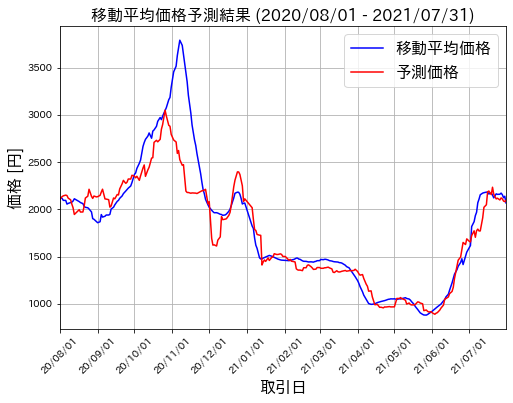

In [175]:
plt.rcParams['figure.subplot.bottom'] = 0.18
fig, ax = plt.subplots()
ax.grid()
fig.set_figwidth(8)
fig.set_figheight(6)

ax.plot(df_plot["date"], data[6][3][403:668], "b", label="移動平均価格")
ax.plot(df_plot["date"], y_preds[6][403:668], "r", label="予測価格")
ax.legend(fontsize=16)
ax.set_xlabel("取引日", fontsize=16)
ax.set_ylabel("価格 [円]", fontsize=16)
ax.set_title("移動平均価格予測結果 (2020/08/01 - 2021/07/31)", fontsize=16)

# Formatterでx軸の日付ラベルを月・日に設定
xfmt = mdates.DateFormatter("%y/%m/%d")
xloc = mdates.MonthLocator()

ax.xaxis.set_major_locator(xloc)
ax.xaxis.set_major_formatter(xfmt)

plt.xticks(rotation=45)
plt.xlim([pd.to_datetime("2020-08-01"), pd.to_datetime("2021-07-31")])

fig.savefig("../images/output3.png")

In [125]:
root_mean_squared_error(y_preds[6], data[6][3])

187.275739116027

In [20]:
y_test_fix = [dtf[3] for dtf in data_fix]

In [21]:
y_c_test_fix = [dcf[3] for dcf in data_c_fix]

## 収穫量データの読み込み

In [22]:
harvest_df_raw = pd.read_csv("../data/harvest.csv", index_col=0)

In [23]:
harvest_df_raw

,month,day,h0,h1
0,11,29,0,71
1,12,6,3,157
2,12,13,145,501
3,12,20,139,445
4,12,27,596,347
5,1,3,451,609
6,1,10,574,314
7,1,17,637,809
8,1,24,661,587
9,1,31,654,817


In [24]:
sim_start_year =  2020

In [25]:
bools = harvest_df_raw.month > 10
years = []
for bool in bools:
    years.append(sim_start_year if bool else sim_start_year+1)

harvest_df_raw["year"] = years

date = [str(harvest_df_raw["year"].iloc[i])+"-"+str(harvest_df_raw["month"].iloc[i])+"-" +
        str(harvest_df_raw["day"].iloc[i]) for i in range(harvest_df_raw.shape[0])]

harvest_df_raw["date"] = pd.to_datetime(date)

harvest_df_raw = harvest_df_raw.drop(["month", "day", "year"], axis=1)

In [26]:
harvest_df_raw["date"] = harvest_df_raw["date"] + pd.Timedelta(days=6)

# 価格データの成形
シミュレーションのためにテストデータ、予測結果に日時を付与

## 入力，各モデルの出力を合わせる

In [27]:
df_test_raw = df.loc[start_test_idx:].copy()
# 予測のもとになった入力データの最後の日の日付
# 最も有効データ数の多い1日後の予測をするモデルに合わせる
datelist = pd.Series([pd.to_datetime(str(int(d["年"]))+"/"+str(int(d["月"]))+"/"+str(int(d["日"]))) for _, d in df_test_raw.iterrows()])

datelist_input = pd.Series([pd.to_datetime(str(int(d["年"]))+"/"+str(int(d["月"]))+"/"+str(int(d["日"]))) for _, d in data[0][1].iterrows()])

# 予測の際の正解データの日付
# 最初を合わせる
datelist_output = [datelist[(n_input-1):][n+1:] for n in range(span)]
# 最後を合わせる
do_len_min = min(list(map(len, datelist_output)))
datelist_output = [do[:do_len_min] for do in datelist_output]

# inputも最後を合わせる
datelist_input = datelist_input[:do_len_min]

In [28]:
# y_preds_with_date = [pd.DataFrame({"date": datelist_output[i].reset_index(drop=True), "y_pred":pd.Series(y_preds_fix[i])}) for i in range(span)]

In [29]:
# y_pred_with_date

## データの結合
date_df: date0, date1,...,date7

pred_df: pr0, pr1,...,pr7

test_df: ts0, ts1,...,ts7

In [30]:
date_df = pd.DataFrame({"input_date":datelist_input.reset_index(drop=True),
                        "output1": datelist_output[0].reset_index(drop=True),
                        "output2": datelist_output[1].reset_index(drop=True),
                        "output3": datelist_output[2].reset_index(drop=True),
                        "output4": datelist_output[3].reset_index(drop=True),
                        "output5": datelist_output[4].reset_index(drop=True),
                        "output6": datelist_output[5].reset_index(drop=True),
                        "output7": datelist_output[6].reset_index(drop=True),
                        "output8": datelist_output[7].reset_index(drop=True),
                        "output9": datelist_output[8].reset_index(drop=True),
                        "output10": datelist_output[9].reset_index(drop=True),
                      })

pred_df = pd.DataFrame({"input_date":datelist_input.reset_index(drop=True),
                        "output1": y_preds_fix[0],
                        "output2": y_preds_fix[1],
                        "output3": y_preds_fix[2],
                        "output4": y_preds_fix[3],
                        "output5": y_preds_fix[4],
                        "output6": y_preds_fix[5],
                        "output7": y_preds_fix[6],
                        "output8": y_preds_fix[7],
                        "output9": y_preds_fix[8],
                        "output10": y_preds_fix[9],
                      })

test_df = pd.DataFrame({"input_date":datelist_input.reset_index(drop=True),
                        "output1": y_c_test_fix[0],
                        "output2": y_c_test_fix[1],
                        "output3": y_c_test_fix[2],
                        "output4": y_c_test_fix[3],
                        "output5": y_c_test_fix[4],
                        "output6": y_c_test_fix[5],
                        "output7": y_c_test_fix[6],
                        "output8": y_c_test_fix[7],
                        "output9": y_c_test_fix[8],
                        "output10": y_c_test_fix[9],
                      })

test_m_df = pd.DataFrame({"input_date":datelist_input.reset_index(drop=True),
                        "output1": y_test_fix[0],
                        "output2": y_test_fix[1],
                        "output3": y_test_fix[2],
                        "output4": y_test_fix[3],
                        "output5": y_test_fix[4],
                        "output6": y_test_fix[5],
                        "output7": y_test_fix[6],
                        "output8": y_test_fix[7],
                        "output9": y_test_fix[8],
                        "output10": y_test_fix[9],
                      })

In [31]:
# 端数処理の影響で若干づれるが，大方誤差予測誤差が一致 → おそらく正しく実装
root_mean_squared_error(test_m_df["output7"], pred_df["output7"])

187.12467325098132

In [32]:
# 参考程度に移動平均前との誤差
root_mean_squared_error(test_df["output7"], pred_df["output7"])

250.1444012312879

## 予測日から4日以降10日以内の結果のみの抽出
シミュレーションのため移動期間，出荷期間を考慮

In [33]:
# bool_df = pd.DataFrame(np.array([(date_df[o_col] - date_df["input_date"]).dt.days <= 10 for o_col in date_df.columns[1:]]).T, columns=test_df.columns[1:])
bool_df1 = pd.DataFrame(np.array([(date_df[o_col] - date_df["input_date"]).dt.days <= 10 for o_col in date_df.columns[1:]]).T, columns=test_df.columns[1:])
bool_df2 = pd.DataFrame(np.array([4 <= (date_df[o_col] - date_df["input_date"]).dt.days for o_col in date_df.columns[1:]]).T, columns=test_df.columns[1:])
bool_df = bool_df1 & bool_df2
bool_df = pd.concat([date_df["input_date"], bool_df.astype(int)], axis=1)

In [34]:
# 平均4日程度から最大を予測し出荷する
valid_day_nums = [bool_df.iloc[i][1:].sum() for i in range(bool_df.shape[0])]
print(np.mean(valid_day_nums))
print(np.max(valid_day_nums))
print(np.min(valid_day_nums))

5.039160839160839
7
2


In [35]:
valid_pred_df = pred_df.copy()
valid_pred_df.iloc[:, 1:] = pred_df.iloc[:, 1:] * bool_df.iloc[:, 1:]

valid_test_df = test_df.copy()
valid_test_df.iloc[:, 1:] = test_df.iloc[:, 1:] * bool_df.iloc[:, 1:]

# valid_date_df = date_df.copy()
# valid_date_df.iloc[:, 1:] = date_df.iloc[:, 1:] & bool_df.iloc[:, 1:].astype(bool)

## 理論値データの作成
test最大に合わせて出荷

In [36]:
# 全実験共通
# 収穫日以降最も近い予測可能日を設定
input_days = []
for hd in harvest_df_raw["date"]:
    diff_days = (valid_test_df["input_date"] - hd).dt.days
    diff_days = diff_days[diff_days>=0]
    min_deltatime = diff_days.min()
    input_day = hd + pd.Timedelta(days=min_deltatime)
    input_days.append(input_day)
harvest_df_raw["input_date"] = input_days

In [37]:
(harvest_df_raw["input_date"] - harvest_df_raw["date"]).value_counts()

0 days    28
2 days     1
3 days     1
dtype: int64

In [38]:
harvest_df_test = pd.merge(harvest_df_raw, valid_test_df)
harvest_df_date = pd.merge(harvest_df_raw, date_df)

In [39]:
harvest_df_max = harvest_df_test.iloc[:,:4].copy()

In [40]:
# 最大の日と価格の計算
max_prices = []
max_dates = []

for hdt in harvest_df_test.index:
    max_price = np.max(harvest_df_test.iloc[hdt, 4:])
    max_date = harvest_df_date.iloc[hdt, np.argmax(harvest_df_test.iloc[hdt, 4:]) + 4]
    max_prices.append(max_price)
    max_dates.append(max_date)

In [41]:
harvest_df_max["max_price"] = max_prices
harvest_df_max["max_date"] = max_dates

In [42]:
max_prices[:2]

[1996, 2312]

In [43]:
max_dates[:2]

[Timestamp('2020-12-15 00:00:00'), Timestamp('2020-12-22 00:00:00')]

一致！！

In [44]:
# 収穫可能日から取引日までの日数
harvest_df_max["day_delta"] = harvest_df_max["max_date"] - harvest_df_max["date"]

In [45]:
harvest_df_max

,h0,h1,date,input_date,max_price,max_date,day_delta
0,0,71,2020-12-05,2020-12-05,1996,2020-12-15,10 days
1,3,157,2020-12-12,2020-12-12,2312,2020-12-22,10 days
2,145,501,2020-12-19,2020-12-19,2108,2020-12-29,10 days
3,139,445,2020-12-26,2020-12-26,2165,2020-12-30,4 days
4,596,347,2021-01-02,2021-01-05,1528,2021-01-14,12 days
5,451,609,2021-01-09,2021-01-09,1528,2021-01-14,5 days
6,574,314,2021-01-16,2021-01-16,1492,2021-01-21,5 days
7,637,809,2021-01-23,2021-01-23,1468,2021-01-30,7 days
8,661,587,2021-01-30,2021-01-30,1498,2021-02-09,10 days
9,654,817,2021-02-06,2021-02-06,1543,2021-02-11,5 days


収穫可能日が予測データにない場合，10日を超える部分も存在

In [46]:
# 利益計算
harvest_df_max["h0_profit"] = harvest_df_max["h0"] * harvest_df_max["max_price"]
harvest_df_max["h1_profit"] = harvest_df_max["h1"] * harvest_df_max["max_price"]

In [47]:
h0_profit_max = harvest_df_max["h0_profit"].sum()
h1_profit_max = harvest_df_max["h1_profit"].sum()

print("profit of h0: ", harvest_df_max["h0_profit"].sum())
print("profit of h1: ", harvest_df_max["h1_profit"].sum())

profit of h0:  19993096
profit of h1:  19010859


## 固定日データの作成
区間から最も近い1日目に合わせて出荷

In [48]:
harvest_df_test = pd.merge(harvest_df_raw, valid_test_df)
harvest_df_date = pd.merge(harvest_df_raw, date_df)

In [49]:
harvest_df_fix = harvest_df_test.iloc[:,:4].copy()

In [50]:
fix_prices = []
fix_dates = []

for hdt in harvest_df_test.index:
    fix_price = harvest_df_test.iloc[hdt, 4:][harvest_df_test.iloc[hdt, 4:]>0][0]
    fix_output = harvest_df_test.iloc[hdt, 4:][harvest_df_test.iloc[hdt, 4:]>0].index[0]
    fix_date = harvest_df_date.iloc[hdt][fix_output]
    fix_prices.append(fix_price)
    fix_dates.append(fix_date)

In [51]:
harvest_df_fix["fix_price"] = fix_prices
harvest_df_fix["fix_date"] = fix_dates

In [52]:
harvest_df_date.iloc[:2]

,h0,h1,date,input_date,output1,output2,output3,output4,output5,output6,output7,output8,output9,output10
0,0,71,2020-12-05,2020-12-05,2020-12-07,2020-12-08,2020-12-10,2020-12-11,2020-12-12,2020-12-14,2020-12-15,2020-12-17,2020-12-18,2020-12-19
1,3,157,2020-12-12,2020-12-12,2020-12-14,2020-12-15,2020-12-17,2020-12-18,2020-12-19,2020-12-21,2020-12-22,2020-12-24,2020-12-25,2020-12-26


In [53]:
harvest_df_test.iloc[:2]

,h0,h1,date,input_date,output1,output2,output3,output4,output5,output6,output7,output8,output9,output10
0,0,71,2020-12-05,2020-12-05,0,0,1913,1949,1927,1967,1996,0,0,0
1,3,157,2020-12-12,2020-12-12,0,0,2023,2099,2154,2274,2312,0,0,0


In [54]:
fix_prices[:2]

[1913, 2023]

In [55]:
fix_dates[:2]

[Timestamp('2020-12-10 00:00:00'), Timestamp('2020-12-17 00:00:00')]

一致！！

In [56]:
# 収穫可能日から取引日までの日数
harvest_df_fix["day_delta"] = harvest_df_fix["fix_date"] - harvest_df_fix["date"]

In [57]:
# 利益計算
harvest_df_fix["h0_profit"] = harvest_df_fix["h0"] * harvest_df_fix["fix_price"]
harvest_df_fix["h1_profit"] = harvest_df_fix["h1"] * harvest_df_fix["fix_price"]

In [58]:
h0_profit_fix = harvest_df_fix["h0_profit"].sum()
h1_profit_fix = harvest_df_fix["h1_profit"].sum()

print("profit of h0: ", harvest_df_fix["h0_profit"].sum())
print("profit of h1: ", harvest_df_fix["h1_profit"].sum())

profit of h0:  19112770
profit of h1:  18273884


In [59]:
harvest_df_fix

,h0,h1,date,input_date,fix_price,fix_date,day_delta,h0_profit,h1_profit
0,0,71,2020-12-05,2020-12-05,1913,2020-12-10,5 days,0,135823
1,3,157,2020-12-12,2020-12-12,2023,2020-12-17,5 days,6069,317611
2,145,501,2020-12-19,2020-12-19,2065,2020-12-24,5 days,299425,1034565
3,139,445,2020-12-26,2020-12-26,2165,2020-12-30,4 days,300935,963425
4,596,347,2021-01-02,2021-01-05,1480,2021-01-09,7 days,882080,513560
5,451,609,2021-01-09,2021-01-09,1461,2021-01-13,4 days,658911,889749
6,574,314,2021-01-16,2021-01-16,1492,2021-01-21,5 days,856408,468488
7,637,809,2021-01-23,2021-01-23,1459,2021-01-28,5 days,929383,1180331
8,661,587,2021-01-30,2021-01-30,1450,2021-02-04,5 days,958450,851150
9,654,817,2021-02-06,2021-02-06,1479,2021-02-10,4 days,967266,1208343


## 提案手法データの作成
y_pred_maxに合わせて出荷

In [60]:
harvest_df_test = pd.merge(harvest_df_raw, valid_test_df)
harvest_df_pred = pd.merge(harvest_df_raw, valid_pred_df)
harvest_df_date = pd.merge(harvest_df_raw, date_df)

In [61]:
harvest_df_pred

,h0,h1,date,input_date,output1,output2,output3,output4,output5,output6,output7,output8,output9,output10
0,0,71,2020-12-05,2020-12-05,0.0,0.00000,1879.318460,1863.338370,1964.325714,1916.844210,1900.451522,0.000000,0.0000,0.0
1,3,157,2020-12-12,2020-12-12,0.0,0.00000,1951.700788,2038.786044,2174.092136,2272.946892,2308.857544,0.000000,0.0000,0.0
2,145,501,2020-12-19,2020-12-19,0.0,0.00000,2097.997495,2208.947299,2284.824847,2199.270953,2249.529811,2087.183225,0.0000,0.0
3,139,445,2020-12-26,2020-12-26,0.0,0.00000,0.000000,2055.224774,2019.685702,0.000000,0.000000,0.000000,0.0000,0.0
4,596,347,2021-01-02,2021-01-05,0.0,0.00000,0.000000,1472.296781,1399.932735,1400.218747,1410.445328,1471.821502,1473.4094,0.0
5,451,609,2021-01-09,2021-01-09,0.0,0.00000,1514.647113,1487.038946,1448.719235,1457.065900,1485.069061,1497.852381,0.0000,0.0
6,574,314,2021-01-16,2021-01-16,0.0,0.00000,1494.150566,1507.538202,1518.314463,1530.701944,1521.897018,0.000000,0.0000,0.0
7,637,809,2021-01-23,2021-01-23,0.0,0.00000,1494.065659,1500.243893,1495.324603,1460.848670,1488.195215,0.000000,0.0000,0.0
8,661,587,2021-01-30,2021-01-30,0.0,0.00000,1452.325870,1460.448271,1456.323367,1484.537293,1442.614110,0.000000,0.0000,0.0
9,654,817,2021-02-06,2021-02-06,0.0,0.00000,1404.886105,1403.655459,1377.720215,1375.292213,1350.778045,1358.012754,0.0000,0.0


In [62]:
harvest_df_prop = harvest_df_pred.iloc[:,:4].copy()

In [63]:
# 最大の日と価格の計算
prop_prices = []
prop_dates = []

for hdt in harvest_df_test.index:
    prop_price = harvest_df_test.iloc[hdt, np.argmax(harvest_df_pred.iloc[hdt, 4:]) + 4]
    prop_date = harvest_df_date.iloc[hdt, np.argmax(harvest_df_pred.iloc[hdt, 4:]) + 4]
    prop_prices.append(prop_price)
    prop_dates.append(prop_date)

In [64]:
harvest_df_prop["prop_price"] = prop_prices
harvest_df_prop["prop_date"] = prop_dates

In [65]:
prop_prices[:2]

[1927, 2312]

In [66]:
prop_dates[:2]

[Timestamp('2020-12-12 00:00:00'), Timestamp('2020-12-22 00:00:00')]

In [67]:
harvest_df_pred.iloc[:2]

,h0,h1,date,input_date,output1,output2,output3,output4,output5,output6,output7,output8,output9,output10
0,0,71,2020-12-05,2020-12-05,0.0,0.0,1879.318460,1863.338370,1964.325714,1916.844210,1900.451522,0.0,0.0,0.0
1,3,157,2020-12-12,2020-12-12,0.0,0.0,1951.700788,2038.786044,2174.092136,2272.946892,2308.857544,0.0,0.0,0.0


In [68]:
harvest_df_test.iloc[:2]

,h0,h1,date,input_date,output1,output2,output3,output4,output5,output6,output7,output8,output9,output10
0,0,71,2020-12-05,2020-12-05,0,0,1913,1949,1927,1967,1996,0,0,0
1,3,157,2020-12-12,2020-12-12,0,0,2023,2099,2154,2274,2312,0,0,0


In [69]:
harvest_df_date.iloc[:2]

,h0,h1,date,input_date,output1,output2,output3,output4,output5,output6,output7,output8,output9,output10
0,0,71,2020-12-05,2020-12-05,2020-12-07,2020-12-08,2020-12-10,2020-12-11,2020-12-12,2020-12-14,2020-12-15,2020-12-17,2020-12-18,2020-12-19
1,3,157,2020-12-12,2020-12-12,2020-12-14,2020-12-15,2020-12-17,2020-12-18,2020-12-19,2020-12-21,2020-12-22,2020-12-24,2020-12-25,2020-12-26


一致！！

In [70]:
# 収穫可能日から取引日までの日数
harvest_df_max["day_delta"] = harvest_df_max["max_date"] - harvest_df_max["date"]

In [71]:
harvest_df_max

,h0,h1,date,input_date,max_price,max_date,day_delta,h0_profit,h1_profit
0,0,71,2020-12-05,2020-12-05,1996,2020-12-15,10 days,0,141716
1,3,157,2020-12-12,2020-12-12,2312,2020-12-22,10 days,6936,362984
2,145,501,2020-12-19,2020-12-19,2108,2020-12-29,10 days,305660,1056108
3,139,445,2020-12-26,2020-12-26,2165,2020-12-30,4 days,300935,963425
4,596,347,2021-01-02,2021-01-05,1528,2021-01-14,12 days,910688,530216
5,451,609,2021-01-09,2021-01-09,1528,2021-01-14,5 days,689128,930552
6,574,314,2021-01-16,2021-01-16,1492,2021-01-21,5 days,856408,468488
7,637,809,2021-01-23,2021-01-23,1468,2021-01-30,7 days,935116,1187612
8,661,587,2021-01-30,2021-01-30,1498,2021-02-09,10 days,990178,879326
9,654,817,2021-02-06,2021-02-06,1543,2021-02-11,5 days,1009122,1260631


In [72]:
harvest_df_prop

,h0,h1,date,input_date,prop_price,prop_date
0,0,71,2020-12-05,2020-12-05,1927,2020-12-12
1,3,157,2020-12-12,2020-12-12,2312,2020-12-22
2,145,501,2020-12-19,2020-12-19,2030,2020-12-26
3,139,445,2020-12-26,2020-12-26,2165,2020-12-30
4,596,347,2021-01-02,2021-01-05,1515,2021-01-15
5,451,609,2021-01-09,2021-01-09,1461,2021-01-13
6,574,314,2021-01-16,2021-01-16,1454,2021-01-25
7,637,809,2021-01-23,2021-01-23,1463,2021-01-29
8,661,587,2021-01-30,2021-01-30,1472,2021-02-08
9,654,817,2021-02-06,2021-02-06,1479,2021-02-10


収穫可能日が予測データにない場合，10日を超える部分も存在

In [73]:
# 利益計算
harvest_df_prop["h0_profit"] = harvest_df_prop["h0"] * harvest_df_prop["prop_price"]
harvest_df_prop["h1_profit"] = harvest_df_prop["h1"] * harvest_df_prop["prop_price"]

In [74]:
h0_profit_prop = harvest_df_prop["h0_profit"].sum()
h1_profit_prop = harvest_df_prop["h1_profit"].sum()

print("profit of h0: ", harvest_df_prop["h0_profit"].sum())
print("profit of h1: ", harvest_df_prop["h1_profit"].sum())

profit of h0:  19466580
profit of h1:  18541644


# 結果の比較

## 理論値 vs 固定

In [75]:
print("提案手法との差分 (h0)", h0_profit_max - h0_profit_fix)
print("提案手法との差分 (h1)", h1_profit_max - h1_profit_fix)

提案手法との差分 (h0) 880326
提案手法との差分 (h1) 736975


## 提案手法 vs 固定

In [76]:
print("提案手法との差分 (h0)", h0_profit_prop - h0_profit_fix)
print("提案手法との差分 (h1)", h1_profit_prop - h1_profit_fix)

提案手法との差分 (h0) 353810
提案手法との差分 (h1) 267760


## 理論値 vs 提案手法

In [77]:
print("提案手法との差分 (h0)", h0_profit_prop - h0_profit_max)
print("提案手法との差分 (h1)", h1_profit_prop - h1_profit_max)

提案手法との差分 (h0) -526516
提案手法との差分 (h1) -469215


## 改善幅を最大1とした時の改善率
理論値にどの程度近付いたか

In [78]:
print("改善率 (h0)", (h0_profit_max - h0_profit_prop)/(h0_profit_max - h0_profit_fix))
print("改善率 (h1)", (h1_profit_max - h1_profit_prop)/(h1_profit_max - h1_profit_fix))

改善率 (h0) 0.5980920704375424
改善率 (h1) 0.6366769564774925


In [79]:
print(h0_profit_max)
print(h0_profit_fix)
print(h0_profit_prop)

print(h1_profit_max)
print(h1_profit_fix)
print(h1_profit_prop)

19993096
19112770
19466580
19010859
18273884
18541644


In [83]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [84]:
df

,年,月,日,曜日,数量,価格,days
0,2012,1,5,3,840793,1525,0
4,2012,1,6,4,528012,1377,1
8,2012,1,7,5,317676,1292,2
12,2012,1,9,0,667,1466,4
15,2012,1,10,1,549611,1234,5
...,...,...,...,...,...,...,...
13463,2021,10,5,1,3786,2521,3561
13466,2021,10,7,3,5602,2491,3563
13470,2021,10,8,4,2980,2165,3564
13474,2021,10,9,5,3349,2347,3565


In [85]:
pred_df

,input_date,output1,output2,output3,output4,output5,output6,output7,output8,output9,output10
0,2019-01-14,1412.104264,1437.295851,1411.446473,1476.654022,1476.991875,1511.336309,1506.591043,1505.899657,1522.553991,1542.749561
1,2019-01-15,1387.433886,1369.015816,1404.576840,1442.482969,1455.006483,1491.271922,1491.554562,1498.001105,1537.949026,1530.688117
2,2019-01-16,1400.787402,1396.127535,1396.046870,1435.381794,1435.760450,1489.342563,1478.840613,1508.321523,1535.185008,1535.261095
3,2019-01-17,1415.201161,1429.336976,1442.439521,1485.417011,1478.480554,1513.176234,1489.247796,1507.299692,1518.671675,1513.004732
4,2019-01-18,1426.813920,1449.329850,1468.053903,1495.291192,1489.835247,1519.721889,1493.036406,1498.154169,1529.422033,1514.637182
...,...,...,...,...,...,...,...,...,...,...,...
710,2021-09-21,2594.244280,2598.782428,2603.979824,2580.925429,2559.180108,2568.268252,2585.369906,2584.670279,2574.479010,2579.855687
711,2021-09-22,2636.857356,2654.291530,2634.745810,2583.835023,2564.487259,2586.966520,2601.767248,2649.456499,2607.268630,2601.038661
712,2021-09-24,2628.026464,2618.499071,2588.588905,2565.418063,2560.273505,2580.948370,2547.006514,2588.584855,2584.235291,2602.809511
713,2021-09-25,2629.948965,2581.520974,2583.871958,2569.704011,2566.339277,2599.239318,2554.415635,2588.773547,2619.961965,2609.906993


9426     1733.399918
9432     1628.760410
9438     1569.194895
9444     1487.608268
9450     1472.025809
            ...     
13463    2617.423355
13466    2556.069065
13470    2471.700930
13474    2437.618034
13479    2418.702479
Name: 価格, Length: 731, dtype: float64

In [89]:
df

,年,月,日,曜日,数量,価格,days
0,2012,1,5,3,840793,1525,0
4,2012,1,6,4,528012,1377,1
8,2012,1,7,5,317676,1292,2
12,2012,1,9,0,667,1466,4
15,2012,1,10,1,549611,1234,5
...,...,...,...,...,...,...,...
13463,2021,10,5,1,3786,2521,3561
13466,2021,10,7,3,5602,2491,3563
13470,2021,10,8,4,2980,2165,3564
13474,2021,10,9,5,3349,2347,3565


In [92]:
df_train

15      1385.449678
19      1288.108584
23      1240.209210
27      1219.679513
31      1215.421850
           ...     
9397    2558.567172
9403    2355.454208
9409    2140.030958
9415    2023.033503
9421    1963.784959
Name: 価格, Length: 1929, dtype: float64